# Approximating Fundamental Domain

Let $f: \mathbb{R}^2 \to \mathbb{R}$ define a periodic tiling of $\mathbb{R}^2$ with wallpaper symmetry. The goal of this notebook is to create an algorithm that can approximate the lattice generators of such a tiling. Let $t_{x,y}$ denote a translation of a tiling by $(x,y)$. Given a lens $L\subset \mathbb{R}^2$ and a tiling $f$, let $L(f)$ denote the lens applied to the tiling. We want to find two linearly indepented translations $t_{x,y}$ and $t_{x',y'}$ such that $d(L(f), L(t_{x,y}(f))$ and $d(L(f), L(t_{x',y'}(f))$ are close to zero, where $d$ denotes Euclidean distance. We also want $(x,y)$ and $(x',y')$ to be as short as possible so we don't overestimate the size of the fundamental domain.

To do this, we will explore three different algorithms:
1) a naive algorithm that randomly samples translations and chooses two that close to isometries
2) an algorithm that relies on the principles of gradient descent 
3) 

In [120]:
from numpy import sin,cos, dot
import numpy as np
from numpy import pi,cos,sin, sqrt
import matplotlib.pyplot as plt
import random
from math import dist
import time
from scipy.spatial.distance import cdist

In [42]:
def get_pixels(num_pixels_x, num_pixels_y, window_x, window_y):
    sample1 = list(np.linspace(-window_x/2, window_x/2, num_pixels_x))
    sample2 = list(np.linspace(-window_y/2, window_y/2, num_pixels_y))
    pixels = []
    for i in range(len(sample1)):
        for j in range(len(sample2)):
            pixels.append((sample1[i],sample2[j]))     
    return pixels


def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  

def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

def generate_isom(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(2 * pi * np.random.random(n_isos)) # sampling from (0, 2pi)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors

def view_window(image_function, num_pixels_x, num_pixels_y, window_x, window_y):
    
    pixels = get_pixels(num_pixels_x, num_pixels_y, window_x, window_y)
    
    x_points = []
    y_points = []
    color = []
    for pixel in pixels:
        x_points.append(pixel[0])
        y_points.append(pixel[1])
        color.append(image_function(pixel[0], pixel[1]))
        
    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = color)
    plt.show()

**Functions with different point groups:**

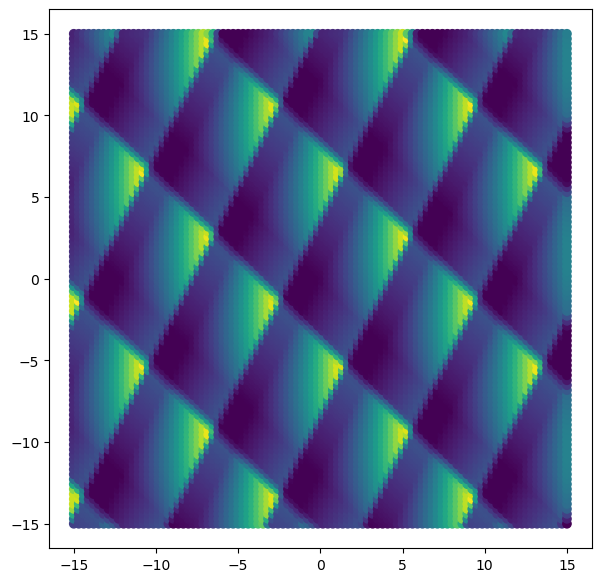

In [92]:
def piecewise(x):
    if 0 <= x%12 <= 8:
        f = .25 * (x % 12) + 1
    elif 8 <= x%12 <= 9:
        f = -2 * (x%12) + 18 +1
    else:
        f = 1
    return f

def c1(x,y):
    return piecewise(x+y) * piecewise(2*x-y)

view_window(image_function = c1, num_pixels_x=100, num_pixels_y=100, window_x=30, window_y=30)

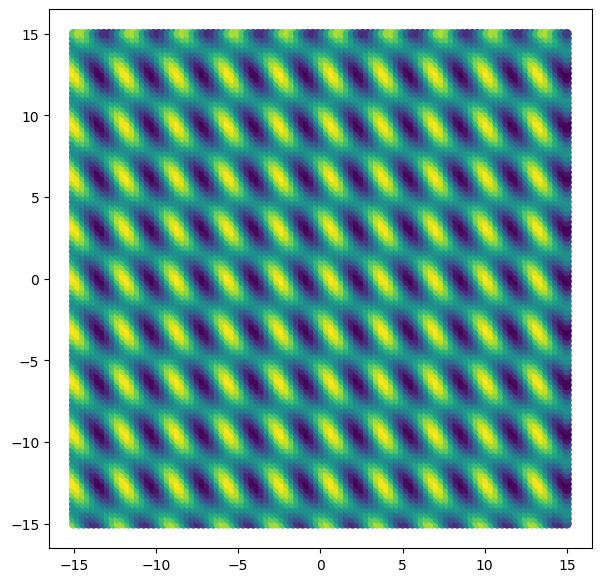

In [61]:
def c2(x,y):
    return sin(2 * x + y) * cos(y)

view_window(image_function = c2, num_pixels_x=100, num_pixels_y=100, window_x=30, window_y=30)

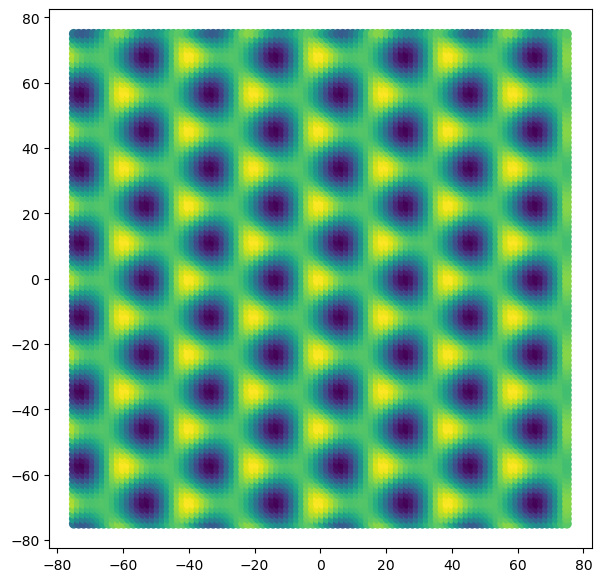

In [62]:
def c3(x,y):
    X = 1/(2 * pi) * (x + y / (3**(1/2)))
    Y = 1/(2 * pi) * 2 * y / (3**(1/2))
    C = cos(X + Y) + cos(X - 2 * Y) + cos(-2 * X + Y)
    S = sin(X + Y) +sin(X - 2*Y) +sin(-2 * X + Y)
    return C + S
    

view_window(image_function = c3, num_pixels_x=100, num_pixels_y=100, window_x=150, window_y=150)

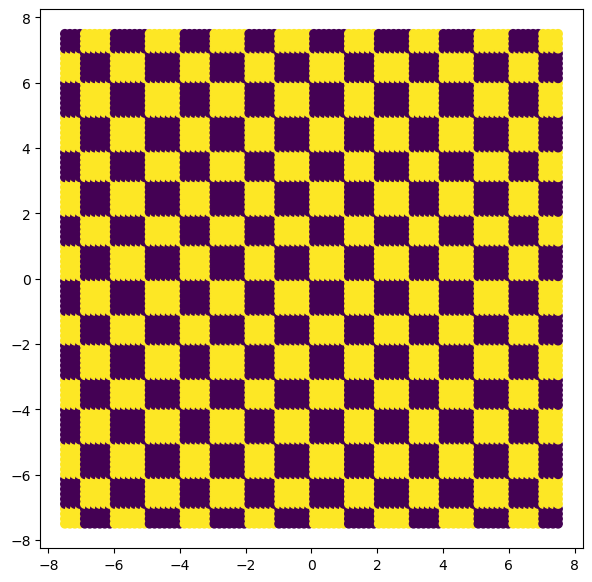

In [96]:
def c4(x,y): 
    if 0 <= x%2 < 1 and 0 <= y%2 < 1:
        res = 1 
    elif 1 <= x%2 < 2 and 1 <= y%2 < 2:
        res = 1
    else: 
        res = 0
    return res

view_window(image_function = c4, num_pixels_x=100, num_pixels_y=100, window_x=15, window_y=15)

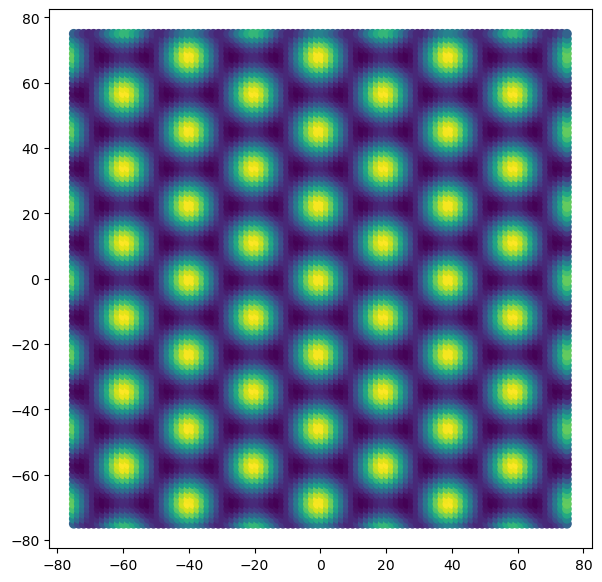

In [115]:
def c6(x,y):
    X = 1/(2 * pi) * (x + y / (3**(1/2)))
    Y = 1/(2 * pi) * 2 * y / (3**(1/2))
    C = cos(X + Y) + cos(X - 2 * Y) + cos(-2 * X + Y)
    S = sin(X + Y) +sin(X - 2*Y) +sin(-2 * X + Y)
    return C 

view_window(image_function = c6, num_pixels_x=100, num_pixels_y=100, window_x=150, window_y=150)

### Method 1: Naive Algorithm

Given a tiling function, we randomly samples translation vectors, and choose two that 
1) are the close to sending the tiling to itself
2) are linearly independent 
3) have length that is relatively close to zero, but not zero

In [121]:
# these functions will be used to make sure the vectors out algorithm chooses are linearly independent

def direction(x,y):
    length = sqrt(x**2 + y**2) 
    if length == 0:
        return (0,0)
    new_x = x/length
    new_y = y/length 
    return (new_x,new_y)

#def magnitude(x,y):
#    return sqrt(x**2 + y**2) 

def same_direction(x1,y1,x2,y2,error):
    dir1 = direction(x1,y1)
    dir2 = direction(x2,y2)
    if abs(dir1[0]-dir2[0])<error and abs(dir1[1]-dir2[1])<error:
        return True 
    elif abs(dir1[0]+dir2[0])<error and abs(dir1[1]+dir2[1])<error:
        return True
    else:
        return False

**The find translations function:** This function begins by taking several random translations. For each of these translations $(x,y)$, it calculates the distance $d(L(f), L(t_{x,y}(f))$ where $f$ is the tiling/image function (unless $(x,y)$ is too close to zero). The translation $t_{x,y}$ with the smallest distance is chosen as the first lattic generator approximator. The translation with the next smallest distance that is linearly independent from the first vector is chosen as the second lattice generator approximator. 

In [127]:
def find_trans(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, num_samples):

    start = time.time()
    
    X = trans_x_bound * np.random.random(num_samples) - trans_x_bound/2
    Y = trans_y_bound * np.random.random(num_samples) - trans_y_bound/2

    M = np.zeros((num_samples, num_pixels_x * num_pixels_y))
    
    pixels = get_pixels(num_pixels_x, num_pixels_y, window_x, window_y)
    colors1 = get_colors(pixels, image_function)

    
    distances = {}    
    for i in range(num_samples):
        x = X[i]
        y = Y[i]
        iso = isom(X[i],Y[i],0)
        colors2 = new_colors(pixels, iso, image_function)
        distances[(X[i], Y[i])] = (cdist(np.array(colors1).reshape(1,-1),np.array(colors2).reshape(1,-1), metric='euclidean')).tolist()[0][0]
    
    distances_list = [(k, v) for k, v in distances.items()]
    distances_list.sort(key=lambda s: s[1])
    keys = [i[0] for i in distances_list[:10]]
    
    lengths = {}
    for i in keys: 
        lengths[i] = dist(i,(0,0))
    lengths_list = [(k, v) for k, v in lengths.items()]
    lengths_list.sort(key=lambda s: s[1])
    
    while same_direction(lengths_list[0][0][0], lengths_list[0][0][1], lengths_list[1][0][0],lengths_list[1][0][1], .25) == True:
        del lengths_list[1]
    vector1 = lengths_list[0][0]
    vector2 = lengths_list[1][0]
    
    end = time.time()
    print('time:' + str(end - start))
    
    return vector1, vector2

In [128]:
image_function = c1
window_x = 100 # size of window in x-axis
window_y = 100 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 50 # length of interval to choose x-translation from 
trans_y_bound = 50 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 1000 # how far from exact translation 


find_trans(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, num_samples)

time:7.368111848831177


((-3.827343082966756, 3.9083048583067814),
 (-3.7889123055399985, -7.654712105427713))

In [129]:
image_function = c2
window_x = 100 # size of window in x-axis
window_y = 100 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 50 # length of interval to choose x-translation from 
trans_y_bound = 50 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 1000 # how far from exact translation 

find_trans(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, num_samples)

time:7.563393831253052


((3.017637029418239, -12.611638365683975),
 (9.305470936519974, -9.45858207093188))

In [130]:
image_function = c3
window_x = 150 # size of window in x-axis
window_y = 150 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 100 # length of interval to choose x-translation from 
trans_y_bound = 100 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 1000 # how far from exact translation 

find_trans(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, num_samples)

time:10.304670810699463


((-0.25525148883874493, 21.573928775984996),
 (-18.392018430681045, -11.468377703737566))

In [131]:
image_function = c4
window_x = 50 # size of window in x-axis
window_y = 50 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 25 # length of interval to choose x-translation from 
trans_y_bound = 25 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 1000 # how far from exact translation 

find_trans(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, num_samples)

time:6.852175951004028


((1.0342878849116666, -4.928460705292206),
 (5.076301701157917, 5.007112934907276))

In [132]:
image_function = c6
window_x = 150 # size of window in x-axis
window_y = 150 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 100 # length of interval to choose x-translation from 
trans_y_bound = 100 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 1000 # how far from exact translation 

find_trans(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, num_samples)

time:10.26867413520813


((-19.24991705006508, -12.600414946913638),
 (-19.760519420401547, 12.123581284680697))

### Method 2: Gradient Descent

**The gradient function:** Choose a lens $L$ and sample a random point $(x,y)\in\mathbb{R}^2$. Approximate the gradient the of $d_L(x,y)$ as 
$$\left(\frac{1}{2\varepsilon} \left( d[L(f), L(t_{x+\varepsilon,y}(f))] - d[L(f), L(t_{x-\varepsilon,y}(f))]\right), \frac{1}{2\varepsilon} \left( d[L(f), L(t_{x,y+\varepsilon}(f))] - d[L(f), L(t_{x,y-\varepsilon}(f))]\right)\right)$$
where $d$ is Euclidean distance.

In [107]:
def gradient(x,y,radius, colors1, image_function, pixels):
    
    x_translation1 = isom(x + radius,y,0)
    x_translation2 = isom(x - radius,y,0)
    y_translation1 = isom(x, y + radius,0)
    y_translation2 = isom(x, y - radius,0)
    
    colors_x1 = new_colors(pixels, x_translation1, image_function)
    colors_x2 = new_colors(pixels, x_translation2, image_function)
    colors_y1 = new_colors(pixels, y_translation1, image_function)
    colors_y2 = new_colors(pixels, y_translation2, image_function)
    
    partial_f_x = 1/(2*radius) * (dist(colors1, colors_x1) - dist(colors1, colors_x2))
    
    partial_f_y = 1/(2*radius) * (dist(colors1, colors_y1) - dist(colors1, colors_y2))
    
    dir_descent = direction(-partial_f_x,-partial_f_y)
    
    while dir_descent == (0,0):
        radius = radius * 2
        dir_descent = gradient(x,y,radius, colors1, image_function, pixels)
    
    #mag = magnitude(partial_f_x,partial_f_y)
    
    return dir_descent

In [37]:
# given a tiling f, small_dist approximates a value that is a relatively small distance between two random translations
def small_dist(image_function, num_pixels_x, num_pixels_y, window_x, window_y, num_sample):

    pixels = get_pixels(num_pixels_x, num_pixels_y, window_x, window_y)
    
    trans_x = trans_x_bound * np.random.random(num_sample) - trans_x_bound/2
    trans_y = trans_y_bound * np.random.random(num_sample) - trans_y_bound/2
    
    isos = []
    for i in range(num_sample):
        isos.append(isom(trans_x[i], trans_y[i], 0))
        
    color1 = get_colors(pixels, image_function)
        
    distances = []
    for iso in isos:
        color2 = new_colors(pixels,iso,image_function)
        distances.append(dist(color1,color2))
    distances = np.array(distances)
    
    return min(distances)/2

**The gradient descent function:** Once we have an approximation of the gradient at a point $(x,y)$, we want to move in the oppostive direction to get close to a translation that takes the tiling to itself. One sticking point in gradient descent is choosing a learning rate, or how far to move in the (opposite) direction of the gradient. We don't want to overshoot it with too large of a learning rate, but we also don't want to take too small of steps and have the algorithm take forever. In the following algorithm, we try several different learning rates (dependent on output from small_dist) at each iteration, and choose the one that gives the smallest $d(x',y')$, where $(x',y')$ defines the new translation that results from moving in the (opposite) direction of the gradient.

In [113]:
def general_grad_des(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_sample):
    X = trans_x_bound * np.random.random(1) - trans_x_bound/2
    Y = trans_y_bound * np.random.random(1) - trans_y_bound/2
    x = X[0]
    y = Y[0]
    
    pixels = get_pixels(num_pixels_x, num_pixels_y, window_x, window_y)
    colors1 = get_colors(pixels, image_function)
    close_enough = small_dist(image_function, num_pixels_x, num_pixels_y, window_x, window_y, num_sample)
    #print(close_enough)
    
    
    
    while True:
        
        colors2 = new_colors(pixels, isom(x,y,0), image_function)
        distance = dist(colors1, colors2)
        #print('trans: ' + '(' + str(x) + ', ' + str(y) + '), ' + 'distance: ' + str(distance))
        
        learning_rates = (close_enough * np.random.random(5)).tolist()
        learning_rates.extend((close_enough/5 *np.random.random(5)).tolist())
        
        dir_descent = gradient(x,y,radius,colors1,image_function, pixels)
        
        possibilities = []
        for rate in learning_rates:
            new_x = x + rate * dir_descent[0]
            new_y = y + rate * dir_descent[1]
            colors2 = new_colors(pixels, isom(new_x,new_y,0), image_function)
            possibilities.append(dist(colors1, colors2))
    
        m = min(possibilities)
        index = possibilities.index(m)
        
        #print('lr: ' + str(learning_rates[index]))
        #print('dd: ' + str(dir_descent))
        
        x = x + learning_rates[index] * dir_descent[0]
        y = y + learning_rates[index] * dir_descent[1]
        
        if dist((x,y),(0,0)) < 2:
            #print('restart')
            X = trans_x_bound * np.random.random(1) - trans_x_bound/2
            Y = trans_y_bound * np.random.random(1) - trans_y_bound/2
            x = X[0]
            y = Y[0]
            
        if distance < close_enough: 
            #print('final: ' + str((x,y)) + ', distance: ' + str(distance))
            #print('done')
            break 
    
    return x,y

**Returning two translation vectors:** We want to use gradient descent to output approximations of lattice generators. We need these vectors to be linearly independent, and we want them to be as short as possible (though we are not guarenteed to get the two shortest). We use a same_direction function to check linear independence, and we run gradient descent multiple times so that we can choose the vectors with the smallest length.

In [89]:
def grad_des_2vec(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_samples, num_descents):
    start = time.time()
    
    vectors = []
    for i in range(num_descents):
        vectors.append(general_grad_des(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_samples))
        
    lengths = {}
    for vector in vectors: 
        lengths[vector] = dist(vector,(0,0))
    lengths_list = [(k, v) for k, v in lengths.items()]
    lengths_list.sort(key=lambda s: s[1])
    
    while same_direction(lengths_list[0][0][0], lengths_list[0][0][1], lengths_list[1][0][0],lengths_list[1][0][1], .25) == True:
        del lengths_list[1]
        #print(lengths_list[1])
        
    vector1 = lengths_list[0][0]
    vector2 = lengths_list[1][0]

    end = time.time()
    print('time:' + str(end - start))
    
    return vector1,vector2

**Testing on wallpaper groups:**

In [93]:
image_function = c1
window_x = 100 # size of window in x-axis
window_y = 100 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 50 # length of interval to choose x-translation from 
trans_y_bound = 50 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 10 # how far from exact translation 
num_descents = 15

grad_des_2vec(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_samples, num_descents)

time:10.940410137176514


((-3.891696780868024, 4.535862202801738),
 (-8.040912083593046, -3.9251994313665186))

In [90]:
image_function = c2
window_x = 100 # size of window in x-axis
window_y = 100 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 50 # length of interval to choose x-translation from 
trans_y_bound = 50 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 10 # how far from exact translation 
num_descents = 15

grad_des_2vec(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_samples, num_descents)

time:7.74902081489563


((-6.354570510838316, 3.2080011058451543),
 (-6.254374806496257, 6.255844634439843))

In [117]:
image_function = c3
window_x = 150 # size of window in x-axis
window_y = 150 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 100 # length of interval to choose x-translation from 
trans_y_bound = 100 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 10 # how far from exact translation 
num_descents = 15

grad_des_2vec(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_samples, num_descents)

time:8.169945240020752


((0.005574798787908064, -22.79089981053163),
 (-19.8161588653299, 11.393766256644172))

In [118]:
image_function = c4
window_x = 50 # size of window in x-axis
window_y = 50 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 25 # length of interval to choose x-translation from 
trans_y_bound = 25 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 10 # how far from exact translation 
num_descents = 15

grad_des_2vec(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_samples, num_descents)

time:10.867688179016113


((-4.991837926286168, -4.965544045978293),
 (1.033336105183336, 9.061312629218444))

In [119]:
image_function = c6
window_x = 150 # size of window in x-axis
window_y = 150 # size of window in y-axis
num_pixels_x = 30 # number of horizontal pixels in lens
num_pixels_y = 30 # number of vertical pixels in lens
trans_x_bound = 100 # length of interval to choose x-translation from 
trans_y_bound = 100 # length of interval to choose x-translation from 
radius = .1 # radius to sample new translations from 
num_samples = 10 # how far from exact translation 
num_descents = 15

grad_des_2vec(image_function, num_pixels_x, num_pixels_y, window_x, window_y, trans_x_bound, trans_y_bound, radius, num_samples, num_descents)

time:7.539530038833618


((19.139496993023474, -11.478644856814665),
 (-0.08520653616917011, -22.71159418578752))